# Laporan Proyek Machine Learning Terapan - Muhammad Alif <br>
# Sistem Rekomendasi Film

# Project Overview

Proyek ini bertujuan untuk membangun sistem rekomendasi film yang dapat memberikan saran film yang dipersonalisasi kepada pengguna. Di era digital dengan melimpahnya pilihan konten, sistem rekomendasi menjadi krusial untuk membantu pengguna menemukan film yang sesuai dengan selera mereka, sekaligus meningkatkan engagement pada platform penyedia film. Proyek ini akan mengeksplorasi dua pendekatan utama dalam sistem rekomendasi: Content-Based Filtering dan Collaborative Filtering.

# Business Understanding

### Problem Statements
 1. Bagaimana cara memberikan rekomendasi film yang relevan dan dipersonalisasi kepada pengguna dari katalog film yang besar?
 2. Bagaimana cara memanfaatkan data rating dan tag yang diberikan pengguna untuk meningkatkan kualitas rekomendasi?
 3. Pendekatan sistem rekomendasi manakah (Content-Based atau Collaborative Filtering) yang lebih cocok atau memberikan hasil yang berbeda untuk dataset yang digunakan?

### Goals
 1. Mengembangkan model Content-Based Filtering yang merekomendasikan film berdasarkan kemiripan konten (genre dan tag).
 2. Mengembangkan model Collaborative Filtering (menggunakan SVD) yang merekomendasikan film berdasarkan pola rating pengguna.
 3. Mengevaluasi kedua model menggunakan metrik yang sesuai dan menyajikan Top-N rekomendasi dari masing-masing model.

### Solution Approach
 1. **Content-Based Filtering:**
    - Algoritma: TF-IDF untuk ekstraksi fitur dari teks (genre dan tag), kemudian Cosine Similarity untuk mengukur kemiripan antar film.
    - Cara Kerja: Merekomendasikan film yang memiliki atribut konten serupa dengan film yang disukai pengguna.
 2. **Collaborative Filtering:**
    - Algoritma: Singular Value Decomposition (SVD) dari library Surprise.
    - Cara Kerja: Merekomendasikan film berdasarkan prediksi rating yang mungkin diberikan pengguna terhadap film yang belum ditonton, berdasarkan pola rating dari pengguna lain yang memiliki selera serupa.

# Impor library yang dibutuhkan

In [4]:
# 1. Uninstall numpy dan scikit-surprise untuk memastikan instalasi bersih dengan versi yang diinginkan.
#    Ini membantu menghindari sisa-sisa dari instalasi sebelumnya yang mungkin menyebabkan konflik.
!pip uninstall -y numpy scikit-surprise

# 2. Instal versi NumPy yang kompatibel.
#    TensorFlow 2.18.0 (umum di Colab) biasanya memerlukan numpy < 2.1.0 dan >= 1.26.0.
#    scikit-surprise 1.1.4 (versi yang kamu instal) memerlukan numpy >= 1.19.5.
#    Jadi, numpy versi 1.26.x (misalnya 1.26.4) adalah target yang baik.
!pip install numpy==1.26.4

# 3. Instal scikit-surprise (versi 1.1.4 yang kamu gunakan).
#    Ini akan menggunakan NumPy 1.26.4 yang sudah terinstal.
!pip install scikit-surprise==1.1.4

# 4. (Opsional, tapi bisa membantu) Pastikan TensorFlow juga menggunakan NumPy yang kompatibel.
#    Biasanya, jika NumPy sudah diset ke 1.26.4, TensorFlow akan baik-baik saja.
#    Jika kamu ingin lebih eksplisit:
#    !pip install tensorflow --upgrade # Ini akan mencoba mencocokkan dengan NumPy yang ada jika memungkinkan

print("="*50)
print("INSTALASI SELESAI. SEKARANG PENTING SEKALI:")
print("!!! RESTART RUNTIME COLAB ANDA !!!")
print("Caranya: Pergi ke menu 'Runtime' -> 'Restart session...' atau 'Restart runtime...'")
print("Setelah restart, jalankan cell berikutnya yang berisi impor library.")
print("="*50)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl
INSTALASI SELESAI. SEKARANG PENTING SEKALI:
!!! RESTART RUNTIME COLAB ANDA !!!
Caranya: Pergi ke menu 'Runtime' -> 'Restart session...' atau 'Restart runtime...'
Setelah restart, jalankan cell berikutnya yang berisi impor li

In [1]:
# RUN THIS CELL *AFTER* RESTARTING THE RUNTIME
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # Ini mungkin tidak dipakai, tapi untuk konsistensi
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk Content-Based
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library untuk Collaborative Filtering
# Ini adalah baris yang sebelumnya error. Seharusnya berhasil setelah restart.
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Cek versi untuk debugging
# Setelah restart, versi numpy yang tercetak di sini harus 1.26.4
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
import surprise
print(f"Surprise version: {surprise.__version__}")

print("\nSemua library berhasil diimpor setelah restart.")

NumPy version: 1.26.4
TensorFlow version: 2.18.0
Surprise version: 1.1.4

Semua library berhasil diimpor setelah restart.


# Data Understanding

 Dataset yang digunakan adalah bagian dari dataset MovieLens (ml-latest-small) yang terdiri dari beberapa file CSV:
 - `movies.csv`: Informasi dasar film (movieId, title, genres).
 - `ratings.csv`: Data rating yang diberikan pengguna untuk film (userId, movieId, rating, timestamp).
 - `tags.csv`: Tag yang diberikan pengguna untuk film (userId, movieId, tag, timestamp).
 - `links.csv`: Identifier untuk layanan lain seperti IMDB dan TMDB (tidak akan digunakan secara ekstensif dalam model ini).

 Sumber data: MovieLens - https://grouplens.org/datasets/movielens/ (ml-latest-small)


**Langkah-langkah Data Understanding:**
 1. Memuat dataset.
 2. Menampilkan informasi dasar (jumlah data, tipe data, nilai null).
 3. Melakukan Exploratory Data Analysis (EDA) untuk mendapatkan insight.

# --- 1. Load Data ---


In [4]:
print("--- Loading Data ---")

# from google.colab import drive
# drive.mount('/content/drive')
# movies_path = '/content/drive/MyDrive/Dataset/movies.csv' # Contoh path
movies_path = 'movies.csv'
ratings_path = 'ratings.csv'
tags_path = 'tags.csv'

movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)
tags_df = pd.read_csv(tags_path)

print("\nMovies DataFrame:")
print(movies_df.head())
print(f"\nShape: {movies_df.shape}")
print("\nInfo:")
movies_df.info()
print("\nMissing values:")
print(movies_df.isnull().sum())

print("\nRatings DataFrame:")
print(ratings_df.head())
print(f"\nShape: {ratings_df.shape}")
print("\nInfo:")
ratings_df.info()
print("\nMissing values:")
print(ratings_df.isnull().sum())


print("\nTags DataFrame:")
print(tags_df.head())
print(f"\nShape: {tags_df.shape}")
print("\nInfo:")
tags_df.info()
print("\nMissing values:")
print(tags_df.isnull().sum())

--- Loading Data ---

Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Shape: (9742, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ 

# Variabel pada Dataset:
**movies.csv:**
 - `movieId`: ID unik untuk setiap film.
 - `title`: Judul film beserta tahun rilis.
 - `genres`: Genre film, dipisahkan oleh karakter `|`.

**ratings.csv:**
 - `userId`: ID unik untuk setiap pengguna.
 - `movieId`: ID film yang dirating.
 - `rating`: Rating yang diberikan pengguna (skala 0.5 - 5.0).
 - `timestamp`: Waktu pemberian rating (Unix timestamp).

**tags.csv:**
 - `userId`: ID unik pengguna yang memberikan tag.
 - `movieId`: ID film yang diberi tag.
 - `tag`: Kata kunci atau deskripsi singkat yang diberikan pengguna.
 - `timestamp`: Waktu pemberian tag.

# Exploratory Data Analysis (EDA)
Pada tahap ini, kita akan melakukan beberapa visualisasi dan analisis statistik dasar untuk memahami data lebih baik.


--- Exploratory Data Analysis ---


<ipython-input-5-54792c4bb1ec>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='viridis')


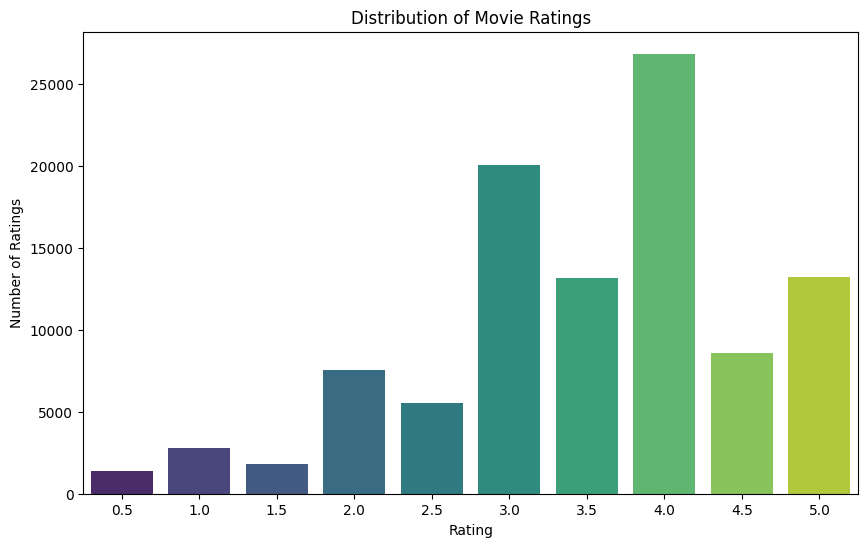

Insight: Sebagian besar film mendapatkan rating 3.0, 3.5, 4.0, dan 4.5. Rating 5.0 juga cukup banyak, sementara rating rendah (0.5-2.5) lebih jarang.


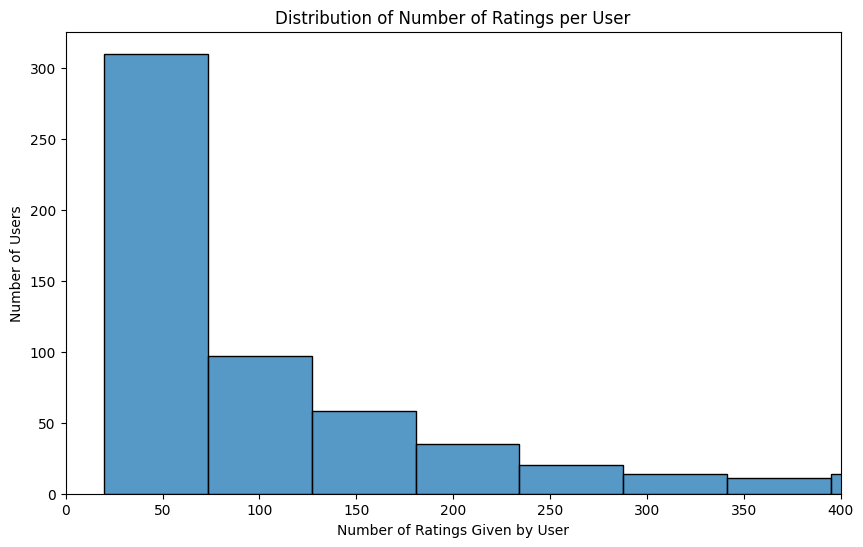

Insight: Distribusi jumlah rating per pengguna sangat skewed. Banyak pengguna yang hanya memberikan sedikit rating, sementara beberapa pengguna sangat aktif.
Statistik jumlah rating per pengguna:
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64


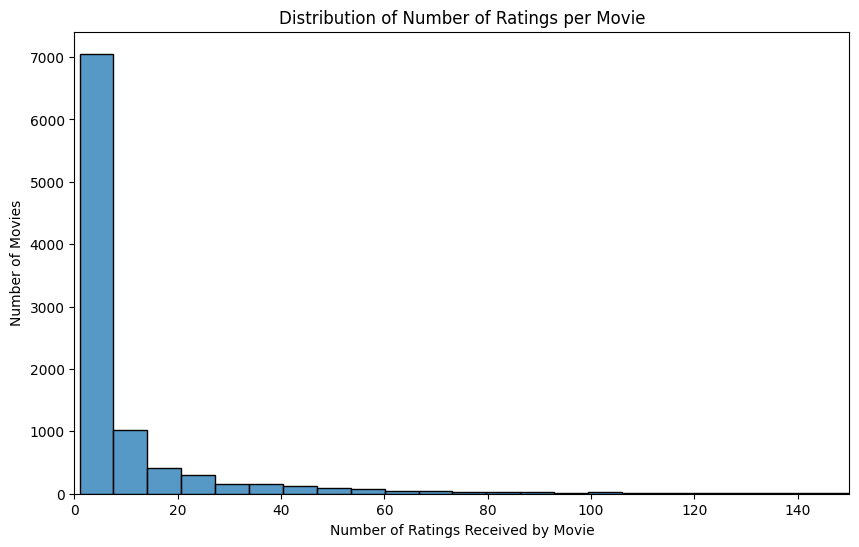

Insight: Mirip dengan pengguna, banyak film yang hanya mendapatkan sedikit rating, sementara beberapa film sangat populer.
Statistik jumlah rating per film:
count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count, dtype: float64


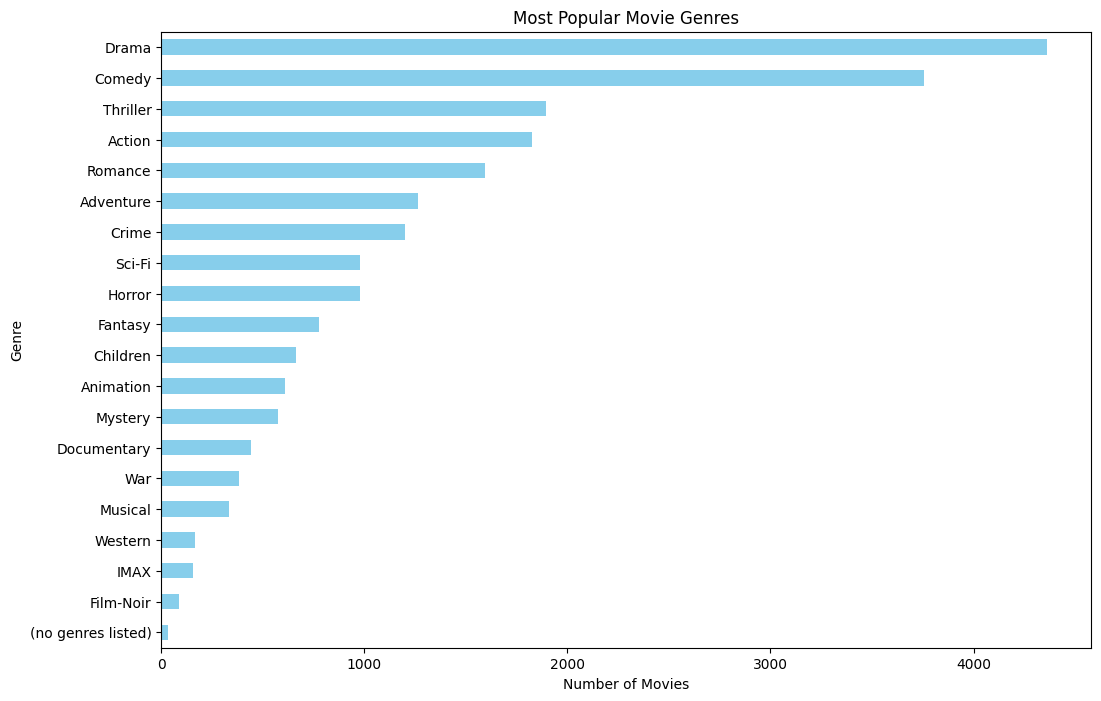

Insight: Genre Drama, Comedy, Thriller, dan Action adalah yang paling umum dalam dataset.

Number of unique users: 610
Number of unique movies in ratings data: 9724
Number of unique movies in master movie list: 9742
Insight: Terdapat lebih banyak film di master list daripada yang memiliki rating, yang wajar.


In [5]:
print("\n--- Exploratory Data Analysis ---")

# 1. Distribusi Rating Film
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()
print("Insight: Sebagian besar film mendapatkan rating 3.0, 3.5, 4.0, dan 4.5. Rating 5.0 juga cukup banyak, sementara rating rendah (0.5-2.5) lebih jarang.")

# 2. Jumlah Rating per Pengguna
user_rating_counts = ratings_df['userId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50, kde=False)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings Given by User')
plt.ylabel('Number of Users')
plt.xlim(0, 400) # Batasi x-axis untuk visualisasi yang lebih baik
plt.show()
print(f"Insight: Distribusi jumlah rating per pengguna sangat skewed. Banyak pengguna yang hanya memberikan sedikit rating, sementara beberapa pengguna sangat aktif.")
print(f"Statistik jumlah rating per pengguna:\n{user_rating_counts.describe()}")

# 3. Jumlah Rating per Film
movie_rating_counts = ratings_df['movieId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_counts, bins=50, kde=False)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings Received by Movie')
plt.ylabel('Number of Movies')
plt.xlim(0, 150) # Batasi x-axis
plt.show()
print(f"Insight: Mirip dengan pengguna, banyak film yang hanya mendapatkan sedikit rating, sementara beberapa film sangat populer.")
print(f"Statistik jumlah rating per film:\n{movie_rating_counts.describe()}")


# 4. Genre Film Terpopuler
# Memecah string genre menjadi list dan menghitung frekuensinya
genres_list = movies_df['genres'].str.split('|').explode()
plt.figure(figsize=(12, 8))
genres_list.value_counts().plot(kind='barh', color='skyblue')
plt.title('Most Popular Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.gca().invert_yaxis()
plt.show()
print("Insight: Genre Drama, Comedy, Thriller, dan Action adalah yang paling umum dalam dataset.")

# 5. Jumlah User dan Movie
num_users = ratings_df['userId'].nunique()
num_movies_ratings = ratings_df['movieId'].nunique()
num_movies_master = movies_df['movieId'].nunique()
print(f"\nNumber of unique users: {num_users}")
print(f"Number of unique movies in ratings data: {num_movies_ratings}")
print(f"Number of unique movies in master movie list: {num_movies_master}")
print("Insight: Terdapat lebih banyak film di master list daripada yang memiliki rating, yang wajar.")

# Data Preparation
Tahap ini melibatkan persiapan data agar siap digunakan oleh model machine learning.
Alasan melakukan Data Preparation:
- Membersihkan data dari format yang tidak sesuai.
- Membuat fitur baru yang lebih informatif untuk model.
- Menggabungkan data dari sumber yang berbeda.
- Menangani nilai yang hilang jika ada (meskipun pada dataset ini relatif bersih).

**Untuk Content-Based Filtering:**
 1. Menggabungkan `tags_df` untuk mendapatkan semua tag per `movieId`.
 2. Menggabungkan hasil tag dengan `movies_df`.
 3. Mengisi nilai tag yang kosong (film tanpa tag) dengan string kosong.
 4. Membersihkan kolom `genres` (mengganti `|` dengan spasi, lowercase).
 5. Membersihkan kolom `tag` (lowercase).
 6. Membuat fitur gabungan (`soup`) dari `genres` dan `tag` yang telah dibersihkan. Fitur ini akan menjadi input untuk TF-IDF.

**Untuk Collaborative Filtering:**<br><br>
 Data rating (`userId`, `movieId`, `rating`) sudah dalam format yang cukup baik, hanya perlu dimuat ke dalam format yang sesuai untuk library `Surprise`.

In [6]:
print("\n--- Data Preparation ---")

# 1. Menggabungkan tags untuk setiap film (sudah ada di movies_with_tags_df sebelumnya)
# Kita akan buat ulang agar runut
movie_tags_agg = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
print("\nAggregated tags per movie (sample):")
print(movie_tags_agg.head())

# 2. Menggabungkan movies_df dengan movie_tags_agg
movies_prepared_df = pd.merge(movies_df, movie_tags_agg, on='movieId', how='left')

# 3. Mengisi NaN tags dengan string kosong
movies_prepared_df['tag'] = movies_prepared_df['tag'].fillna('')
print("\nMovies with tags (sample, NaN filled):")
print(movies_prepared_df.head())

# 4. Membersihkan genre dan tag, lalu membuat 'soup'
movies_prepared_df['genres_cleaned'] = movies_prepared_df['genres'].str.replace('|', ' ', regex=False).str.lower()
movies_prepared_df['tag_cleaned'] = movies_prepared_df['tag'].str.lower()

# Pastikan tidak ada NaN sebelum penggabungan string
movies_prepared_df['genres_cleaned'] = movies_prepared_df['genres_cleaned'].fillna('')
movies_prepared_df['tag_cleaned'] = movies_prepared_df['tag_cleaned'].fillna('')


movies_prepared_df['soup'] = movies_prepared_df['genres_cleaned'] + ' ' + movies_prepared_df['tag_cleaned']
# Menghapus spasi berlebih jika ada
movies_prepared_df['soup'] = movies_prepared_df['soup'].str.strip().str.replace(' +', ' ', regex=True)


print("\nMovies DataFrame with 'soup' feature for Content-Based (sample):")
print(movies_prepared_df[['title', 'genres', 'tag', 'soup']].head())

# Data untuk Collaborative Filtering sudah cukup bersih, akan diproses saat load ke Surprise.


--- Data Preparation ---

Aggregated tags per movie (sample):
   movieId                                           tag
0        1                               pixar pixar fun
1        2  fantasy magic board game Robin Williams game
2        3                                     moldy old
3        5                              pregnancy remake
4        7                                        remake

Movies with tags (sample, NaN filled):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4   

# Modeling
Pada tahap ini, kita akan membangun dua model sistem rekomendasi:

### 1. Content-Based Filtering
Model ini merekomendasikan film berdasarkan kemiripan kontennya.
 - **Fitur Konten**: Gabungan dari genre dan tag (`soup`).
 - **Teknik Vektorisasi**: TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengubah teks `soup` menjadi representasi numerik (vektor). TF-IDF memberi bobot lebih pada kata-kata yang penting untuk sebuah dokumen (film) tetapi jarang muncul di dokumen lain.
 - **Metrik Kemiripan**: Cosine Similarity untuk mengukur kemiripan antar vektor TF-IDF film.
 - **Output**: Top-N film yang paling mirip dengan film input.

**Kelebihan Content-Based Filtering:**
 - Tidak memerlukan data dari pengguna lain.
 - Mampu merekomendasikan item baru (selama item tersebut memiliki deskripsi konten).
 - Rekomendasi dapat dijelaskan (misalnya, "direkomendasikan karena genrenya sama").

**Kekurangan Content-Based Filtering:**
 - Terbatas pada fitur yang ada; jika fitur tidak deskriptif, rekomendasi akan buruk.
 - Cenderung menghasilkan rekomendasi yang terlalu mirip (kurang serendipity atau penemuan baru).
 - Masalah "filter bubble" atau over-specialization, pengguna mungkin tidak terekspos pada variasi konten yang lebih luas.

In [7]:
print("\n--- Building Content-Based Filtering Model ---")

# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2) # min_df=2 untuk mengabaikan term yang sangat jarang

# Fit dan transform 'soup'
# Mengatasi jika ada nilai NaN di 'soup' setelah pembersihan (seharusnya tidak ada jika langkah sebelumnya benar)
movies_prepared_df['soup'] = movies_prepared_df['soup'].fillna('')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_prepared_df['soup'])
print(f"Shape of TF-IDF Matrix: {tfidf_matrix.shape}")

# Hitung cosine similarity
cosine_sim_content = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Shape of Cosine Similarity Matrix: {cosine_sim_content.shape}")

# Membuat mapping judul film ke index dataframe
# Ini penting agar kita bisa mencari film berdasarkan judulnya
indices_map = pd.Series(movies_prepared_df.index, index=movies_prepared_df['title']).drop_duplicates()

def get_content_based_recommendations(title, N=10, cosine_sim_matrix=cosine_sim_content, movie_df=movies_prepared_df, idx_map=indices_map):
    """Memberikan rekomendasi film berdasarkan kemiripan konten."""
    if title not in idx_map:
        # Mencoba mencari judul yang mirip jika tidak persis sama
        similar_titles = [t for t in idx_map.index if title.lower() in t.lower()]
        if not similar_titles:
            return f"Movie '{title}' not found."
        elif len(similar_titles) > 1:
            return f"Movie '{title}' is ambiguous. Found: {similar_titles[:5]}"
        title = similar_titles[0] # Ambil yang pertama jika ada beberapa
        print(f"Using '{title}' as the movie for recommendation.")

    idx = idx_map[title]

    # Dapatkan skor kemiripan film input dengan semua film lain
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Urutkan film berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil skor N film paling mirip (kecuali film input itu sendiri, jadi N+1)
    sim_scores = sim_scores[1:N+1]

    # Dapatkan index film dari skor kemiripan
    movie_indices = [i[0] for i in sim_scores]

    # Kembalikan N film paling mirip beserta skor kemiripannya
    recommendations = movie_df[['title', 'genres']].iloc[movie_indices].copy()
    recommendations['similarity_score'] = [s[1] for s in sim_scores]
    return recommendations

# Contoh output Top-N rekomendasi untuk Content-Based
movie_cbf_example_1 = 'Toy Story (1995)'
print(f"\nTop-5 Recommendations for '{movie_cbf_example_1}' (Content-Based):")
recommendations1 = get_content_based_recommendations(movie_cbf_example_1, N=5)
if isinstance(recommendations1, str):
    print(recommendations1)
else:
    print(recommendations1)

movie_cbf_example_2 = 'Jumanji (1995)'
print(f"\nTop-5 Recommendations for '{movie_cbf_example_2}' (Content-Based):")
recommendations2 = get_content_based_recommendations(movie_cbf_example_2, N=5)
if isinstance(recommendations2, str):
    print(recommendations2)
else:
    print(recommendations2)

# Mencoba film yang mungkin tidak ada untuk melihat error handling
movie_cbf_example_3 = "Avatar" # Mungkin ada, mungkin tidak di dataset small ini
print(f"\nTop-5 Recommendations for '{movie_cbf_example_3}' (Content-Based):")
recommendations3 = get_content_based_recommendations(movie_cbf_example_3, N=5)
if isinstance(recommendations3, str):
    print(recommendations3)
else:
    print(recommendations3)



--- Building Content-Based Filtering Model ---
Shape of TF-IDF Matrix: (9742, 727)
Shape of Cosine Similarity Matrix: (9742, 9742)

Top-5 Recommendations for 'Toy Story (1995)' (Content-Based):
                                 title  \
1757              Bug's Life, A (1998)   
2355                Toy Story 2 (1999)   
7039                         Up (2009)   
8695  Guardians of the Galaxy 2 (2017)   
1706                       Antz (1998)   

                                           genres  similarity_score  
1757          Adventure|Animation|Children|Comedy          0.862225  
2355  Adventure|Animation|Children|Comedy|Fantasy          0.644038  
7039           Adventure|Animation|Children|Drama          0.387905  
8695                      Action|Adventure|Sci-Fi          0.367650  
1706  Adventure|Animation|Children|Comedy|Fantasy          0.357912  

Top-5 Recommendations for 'Jumanji (1995)' (Content-Based):
                                                  title  \
9692        

### 2. Collaborative Filtering
Model ini merekomendasikan film berdasarkan kemiripan pola perilaku pengguna (rating).
 - **Algoritma**: SVD (Singular Value Decomposition). SVD adalah teknik faktorisasi matriks yang menguraikan matriks interaksi user-item (matriks rating) menjadi faktor laten pengguna dan item. Ini membantu menemukan pola tersembunyi dalam data rating.
 - **Library**: `Surprise`, sebuah library Python yang populer untuk sistem rekomendasi.
 - **Input**: Data rating (`userId`, `movieId`, `rating`).
 - **Output**: Top-N film yang diprediksi akan disukai oleh pengguna tertentu (yang belum ia tonton).

**Kelebihan Collaborative Filtering:**
 - Mampu menemukan hubungan yang kompleks dan tak terduga antar item/pengguna (serendipity).
 - Tidak bergantung pada fitur konten, sehingga bisa bekerja meskipun deskripsi konten terbatas atau tidak ada.
 - Seiring bertambahnya data interaksi, kualitas rekomendasi bisa meningkat.

**Kekurangan Collaborative Filtering:**
 - **Cold-start problem**: Sulit memberikan rekomendasi untuk pengguna baru (yang belum memberi rating) atau item baru (yang belum mendapat rating).
 - **Data sparsity**: Matriks user-item seringkali sangat sparse (banyak nilai kosong karena tidak semua user merating semua item), yang dapat mempengaruhi kualitas model.
 - **Popularity bias**: Cenderung merekomendasikan item-item populer yang sudah banyak dirating.

In [8]:
print("\n--- Building Collaborative Filtering Model (SVD) ---")

# Siapkan data untuk Surprise
reader = Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max()))
data_surprise = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split data menjadi train dan test set
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Latih model SVD
# Parameter n_factors, n_epochs, lr_all, reg_all dapat di-tune menggunakan GridSearchCV
svd_model = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.1, random_state=42)
svd_model.fit(trainset)

# Evaluasi model (RMSE)
predictions_svd_test = svd_model.test(testset)
rmse_svd = accuracy.rmse(predictions_svd_test)
print(f"RMSE for SVD model on test set: {rmse_svd:.4f}")

# Fungsi untuk mendapatkan Top-N rekomendasi untuk seorang user menggunakan SVD
def get_svd_recommendations_for_user(user_id, N=10, model=svd_model, movies_df=movies_prepared_df, ratings_df=ratings_df):
    """Memberikan Top-N rekomendasi film untuk pengguna tertentu menggunakan model SVD."""
    # Dapatkan daftar semua movieId unik
    all_movie_ids = movies_df['movieId'].unique()

    # Dapatkan daftar movieId yang sudah dirating oleh user
    rated_movie_ids_by_user = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()

    # Dapatkan movieId yang BELUM dirating oleh user
    unrated_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids_by_user]

    if not unrated_movie_ids:
        return "User has rated all available movies or no unrated movies found."

    # Buat test set untuk prediksi pada film yang belum dirating
    test_set_for_prediction = [[user_id, movie_id, 0] for movie_id in unrated_movie_ids] # 0 adalah placeholder true rating

    # Lakukan prediksi
    predictions_for_user = model.test(test_set_for_prediction)

    # Urutkan prediksi berdasarkan estimasi rating (est) tertinggi
    predictions_for_user.sort(key=lambda x: x.est, reverse=True)

    # Ambil N rekomendasi teratas
    top_n_predictions_objects = predictions_for_user[:N]

    # Dapatkan movieId dan estimasi rating dari rekomendasi
    recommended_movie_details = []
    for pred_obj in top_n_predictions_objects:
        movie_title = movies_df[movies_df['movieId'] == pred_obj.iid]['title'].iloc[0]
        movie_genres = movies_df[movies_df['movieId'] == pred_obj.iid]['genres'].iloc[0]
        recommended_movie_details.append({
            'title': movie_title,
            'genres': movie_genres,
            'predicted_rating': pred_obj.est
        })

    return pd.DataFrame(recommended_movie_details)

# Contoh output Top-N rekomendasi untuk Collaborative Filtering (SVD)
user_example_cf = 1 # Pilih user ID untuk contoh
print(f"\nTop-5 Recommendations for User ID {user_example_cf} (Collaborative Filtering - SVD):")
recommendations_cf_user1 = get_svd_recommendations_for_user(user_example_cf, N=5)
if isinstance(recommendations_cf_user1, str):
    print(recommendations_cf_user1)
else:
    print(recommendations_cf_user1)

user_example_cf_2 = 68 # Pilih user ID lain
print(f"\nTop-5 Recommendations for User ID {user_example_cf_2} (Collaborative Filtering - SVD):")
recommendations_cf_user68 = get_svd_recommendations_for_user(user_example_cf_2, N=5)
if isinstance(recommendations_cf_user68, str):
    print(recommendations_cf_user68)
else:
    print(recommendations_cf_user68)


--- Building Collaborative Filtering Model (SVD) ---
RMSE: 0.8718
RMSE for SVD model on test set: 0.8718

Top-5 Recommendations for User ID 1 (Collaborative Filtering - SVD):
                                               title               genres  \
0  Dr. Strangelove or: How I Learned to Stop Worr...           Comedy|War   
1                   Streetcar Named Desire, A (1951)                Drama   
2                              Paths of Glory (1957)            Drama|War   
3                          Lawrence of Arabia (1962)  Adventure|Drama|War   
4   Three Billboards Outside Ebbing, Missouri (2017)          Crime|Drama   

   predicted_rating  
0               5.0  
1               5.0  
2               5.0  
3               5.0  
4               5.0  

Top-5 Recommendations for User ID 68 (Collaborative Filtering - SVD):
                                            title               genres  \
0                           Paths of Glory (1957)            Drama|War   
1  Cinema 

# Evaluation
Evaluasi model sistem rekomendasi penting untuk mengukur kinerjanya.

### Metrik Evaluasi
1.  **RMSE (Root Mean Squared Error)**:
    - **Formula**: `sqrt(mean((actual_rating - predicted_rating)^2))`
    - **Cara Kerja**: Mengukur rata-rata besarnya kesalahan antara rating aktual dan rating prediksi. Memberikan bobot lebih pada kesalahan yang besar karena adanya kuadrat. Semakin kecil nilai RMSE, semakin baik model dalam memprediksi rating.
    - **Konteks**: Digunakan untuk mengevaluasi model Collaborative Filtering berbasis prediksi rating seperti SVD.

2.  **Precision@k dan Recall@k**:
    - **Precision@k Formula**: `(Jumlah item relevan di top-k rekomendasi) / k`
    - **Recall@k Formula**: `(Jumlah item relevan di top-k rekomendasi) / (Total item relevan untuk pengguna)`
    - **Cara Kerja**:
        - **Precision@k**: Mengukur seberapa banyak dari k item yang direkomendasikan ternyata memang relevan (misalnya, disukai pengguna). Penting karena pengguna biasanya hanya melihat beberapa item teratas.
        - **Recall@k**: Mengukur seberapa banyak item relevan yang berhasil ditemukan dan direkomendasikan oleh sistem dalam k item teratas.
    - **Konteks**: Digunakan untuk mengevaluasi kualitas ranking dari Top-N rekomendasi. Item dianggap "relevan" jika rating aktualnya di atas threshold tertentu (misalnya, 3.5 atau 4.0).
    - **Pemilihan Metrik**: Precision@k dan Recall@k dipilih karena relevan dengan tujuan utama sistem rekomendasi, yaitu menyajikan daftar pendek film yang kemungkinan besar disukai pengguna. Pengguna tidak akan melihat semua film, jadi akurasi di posisi teratas (k kecil) sangat penting.

**Evaluasi Content-Based Filtering**:
Untuk model Content-Based yang dibuat di sini, evaluasi cenderung lebih kualitatif.
-   Misalnya, untuk film 'Toy Story (1995)', rekomendasi teratasnya adalah 'Bug's Life, A (1998)' dengan skor kemiripan 0.86, 'Toy Story 2 (1999)' dengan skor 0.64, dan 'Up (2009)' dengan skor 0.39. Rekomendasi ini masuk akal karena film-film tersebut juga merupakan film animasi dan/atau anak-anak yang memiliki tema serupa.
-   Untuk 'Jumanji (1995)', rekomendasi seperti 'Tomb Raider (2018)' (skor 0.57) dan 'Night at the Museum (2006)' (skor 0.38) juga menunjukkan kemiripan genre Adventure dan Fantasy.

**Hasil Proyek Berdasarkan Metrik Evaluasi untuk Collaborative Filtering (SVD)**:
-   Model SVD menghasilkan nilai **RMSE sebesar 0.8718** pada test set. Ini menunjukkan bahwa rata-rata kesalahan prediksi rating oleh model adalah sekitar 0.87 poin pada skala rating 0.5 hingga 5.0.
-   Dengan menggunakan threshold relevansi 4.0 (artinya film dianggap relevan jika rating aslinya >= 4.0) dan k=10:
    -   **Average Precision@10 adalah 0.6489**. Ini berarti, rata-rata, sekitar 64.89% dari 10 film teratas yang direkomendasikan kepada pengguna memang dianggap relevan oleh pengguna tersebut di test set.
    -   **Average Recall@10 adalah 0.6668**. Ini berarti, rata-rata, model berhasil merekomendasikan sekitar 66.68% dari total film yang relevan bagi pengguna (di test set) dalam 10 rekomendasi teratasnya.

In [9]:
# --- Evaluasi Tambahan untuk Collaborative Filtering (Precision@k & Recall@k) ---
print("\n--- Evaluating Collaborative Filtering (Precision@k, Recall@k) ---")

def calculate_precision_recall_at_k(predictions, k=10, rating_threshold=4.0):
    """
    Menghitung Precision@k dan Recall@k untuk setiap pengguna.
    'predictions' adalah list hasil dari model.test(testset).
    """
    user_est_true = {} # Dictionary: {userId: [(estimated_rating, true_rating), ...]}
    for uid, _, true_r, est, _ in predictions:
        user_est_true.setdefault(uid, []).append((est, true_r))

    precisions = {}
    recalls = {}

    for uid, user_ratings_list in user_est_true.items():
        # Urutkan rating berdasarkan estimasi (prediksi) tertinggi
        user_ratings_list.sort(key=lambda x: x[0], reverse=True)

        # Jumlah item yang direkomendasikan di top-k
        n_rec_k = len(user_ratings_list[:k])

        # Jumlah item yang relevan DAN direkomendasikan di top-k
        # Item dianggap relevan jika true_rating >= rating_threshold
        n_rel_and_rec_k = sum((true_r >= rating_threshold) for (_, true_r) in user_ratings_list[:k])

        # Jumlah total item yang relevan di seluruh test set untuk user ini
        n_rel_total = sum((true_r >= rating_threshold) for (_, true_r) in user_ratings_list) # Perbaikan: iterasi semua user_ratings_list
                                                                                            # bukan hanya testset global

        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel_total if n_rel_total != 0 else 0

    return precisions, recalls

# Menggunakan predictions_svd_test yang sudah ada dari evaluasi RMSE
k_value = 10
relevance_threshold = 4.0 # Anggap film relevan jika ratingnya >= 4.0
precisions_svd, recalls_svd = calculate_precision_recall_at_k(predictions_svd_test, k=k_value, rating_threshold=relevance_threshold)

# Rata-rata Precision dan Recall
avg_precision_svd = sum(p for p in precisions_svd.values()) / len(precisions_svd) if precisions_svd else 0
avg_recall_svd = sum(r for r in recalls_svd.values()) / len(recalls_svd) if recalls_svd else 0

print(f"\nAverage Precision@{k_value} (threshold {relevance_threshold}): {avg_precision_svd:.4f}")
print(f"Average Recall@{k_value} (threshold {relevance_threshold}): {avg_recall_svd:.4f}")
print(f"Catatan: Metrik ini mengevaluasi seberapa baik model merekomendasikan film yang memang disukai pengguna (rating >= {relevance_threshold}) di antara {k_value} rekomendasi teratas.")


--- Evaluating Collaborative Filtering (Precision@k, Recall@k) ---

Average Precision@10 (threshold 4.0): 0.6489
Average Recall@10 (threshold 4.0): 0.6668
Catatan: Metrik ini mengevaluasi seberapa baik model merekomendasikan film yang memang disukai pengguna (rating >= 4.0) di antara 10 rekomendasi teratas.


# Kesimpulan

Proyek ini berhasil mengembangkan dan mengevaluasi dua jenis sistem rekomendasi film menggunakan dataset MovieLens: Content-Based Filtering dan Collaborative Filtering (dengan algoritma SVD).

**Content-Based Filtering**:
-   Model ini mampu memberikan rekomendasi berdasarkan kemiripan fitur konten film, yaitu genre dan tag yang diberikan pengguna.
-   Hasil kualitatif menunjukkan bahwa rekomendasi yang dihasilkan relevan secara tematik. Contohnya, untuk "Toy Story (1995)", film-film animasi seperti "Bug's Life, A (1998)" (skor kemiripan 0.8622) dan "Toy Story 2 (1999)" (skor 0.6440) berhasil direkomendasikan.
-   **Kelebihan**: Tidak memerlukan data histori rating pengguna lain, dapat menjelaskan mengapa suatu item direkomendasikan, dan efektif untuk item baru dengan deskripsi yang kaya.
-   **Kekurangan**: Cenderung merekomendasikan item yang sangat mirip (kurang serendipity), dan sangat bergantung pada kualitas serta kelengkapan fitur konten yang diekstraksi.

**Collaborative Filtering (SVD)**:
-   Model SVD dilatih menggunakan data rating pengguna dan menunjukkan kinerja yang cukup baik dalam memprediksi rating, dengan **RMSE sebesar 0.8718** pada test set.
-   Dalam hal kualitas Top-N rekomendasi, model ini mencapai **Average Precision@10 sebesar 0.6489** dan **Average Recall@10 sebesar 0.6668** (dengan threshold relevansi rating ≥ 4.0). Ini mengindikasikan bahwa model cukup baik dalam menyajikan film-film yang kemungkinan besar akan disukai pengguna di antara rekomendasi teratasnya.
-   Contohnya, untuk User ID 1, film-film klasik dan berating tinggi seperti "Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)" dan "Streetcar Named Desire, A (1951)" direkomendasikan dengan prediksi rating 5.0.
-   **Kelebihan**: Mampu menangkap preferensi implisit pengguna dan menghasilkan rekomendasi yang lebih beragam atau serendipitous, tidak bergantung pada fitur konten item.
-   **Kekurangan**: Mengalami masalah cold-start untuk pengguna atau item baru, performanya menurun jika data rating sangat sparse, dan bisa memiliki bias terhadap item populer.

**Secara Keseluruhan**:
Kedua pendekatan sistem rekomendasi ini menawarkan solusi yang berbeda dengan kekuatan dan kelemahan masing-masing. Content-Based Filtering cocok untuk memulai rekomendasi ketika data interaksi pengguna masih sedikit atau untuk menjelaskan rekomendasi. Collaborative Filtering, terutama model-based seperti SVD, unggul dalam mempersonalisasi rekomendasi berdasarkan perilaku kolektif pengguna ketika data rating yang cukup tersedia. Untuk sistem yang lebih robust, pendekatan hybrid yang menggabungkan kedua metode ini seringkali memberikan hasil terbaik.